In [33]:
# from bokeh.plotting import figure
# from bokeh.io import show, output_notebook
# from bokeh.layouts import column, row
# from bokeh.models import Range1d
# output_notebook()

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 50})

%matplotlib inline

import seaborn as sns
sns.set(font_scale=3)
sns.set_style('ticks')

import numpy as np

from resistingrhythm.util import poisson_impulse
from resistingrhythm.util import poisson_oscillation
from resistingrhythm.util import current_pulse
from resistingrhythm.util import load_spikes
from resistingrhythm.util import create_times
from resistingrhythm.neurons import HHH

import neurodsp

from fakespikes import neurons, rates
from fakespikes import util as fsutil

import warnings
warnings.filterwarnings("ignore")

# Load data

In [37]:
lfp_raw = np.load('/Users/qualia/Code/resistingrhythm/data/ca1.npy')

sampling_rate = 1252
lfp_times = np.arange(0, len(lfp_raw)/sampling_rate, 1/sampling_rate)
f_theta = (4, 10)

# Select a window of data

to work with throughout

In [40]:
max_t = 20
m = lfp_times <= max_t

lfp_times = lfp_times[m]
lfp_raw = lfp_raw[m]

In [92]:
lfp_raw.shape, lfp_times.shape

((25041,), (25041,))

# Visual LFP

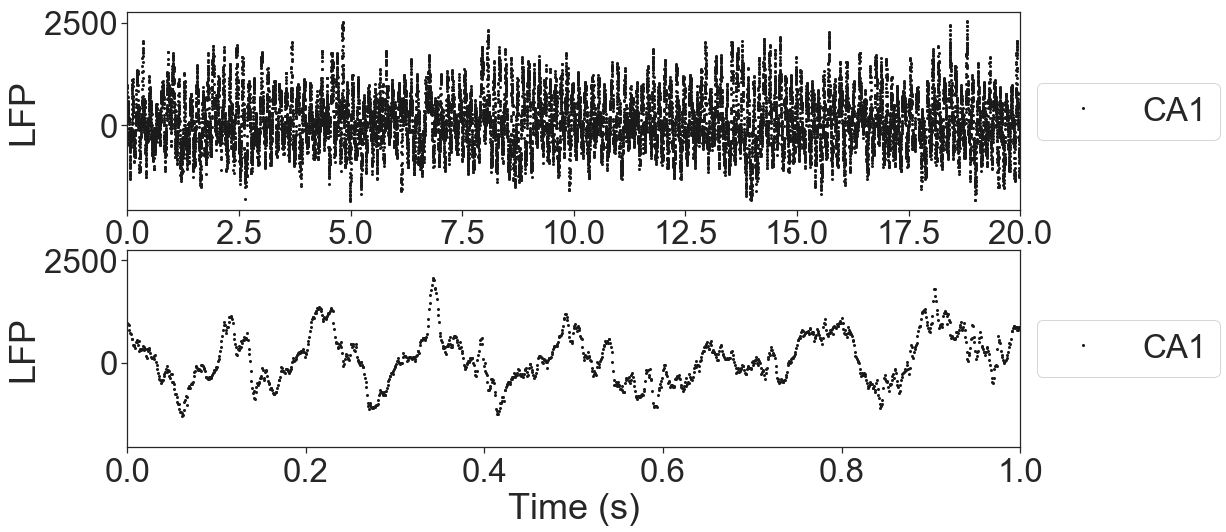

In [93]:
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(2, figsize=(16, 8))

# Drives
_ = ax[0].plot(lfp_times, lfp_raw, markersize=2, marker='o', linestyle='', color='k', label='CA1')
_ = ax[0].set_xlabel("Time (s)")
_ = ax[0].set_ylabel("LFP")
_ = ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax[0].set_xlim(0, 20)

_ = ax[1].plot(lfp_times, lfp_raw, markersize=2, marker='o', linestyle='', color='k', label='CA1')
_ = ax[1].set_xlabel("Time (s)")
_ = ax[1].set_ylabel("LFP")
_ = ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax[1].set_xlim(0, 1)

# Poisson firing

For the lfp

In [94]:
# Poisson sample the rate over w
t = lfp_times.max()
n = 1000
osc_rate = 3
dt = 1 / sampling_rate

# Init
nrns = neurons.Spikes(n, t, dt=dt, refractory=dt, seed=None)

# Normalize lfp -> (0, 1)
drive = (lfp_raw - np.min(lfp_raw)) / (np.max(lfp_raw) - np.min(lfp_raw)) 

# Make spikes
firing_rate = nrns.poisson(osc_rate * drive[0:-1])
ns, ts = fsutil.to_spiketimes(lfp_times[0:-1], firing_rate)

### Visualize

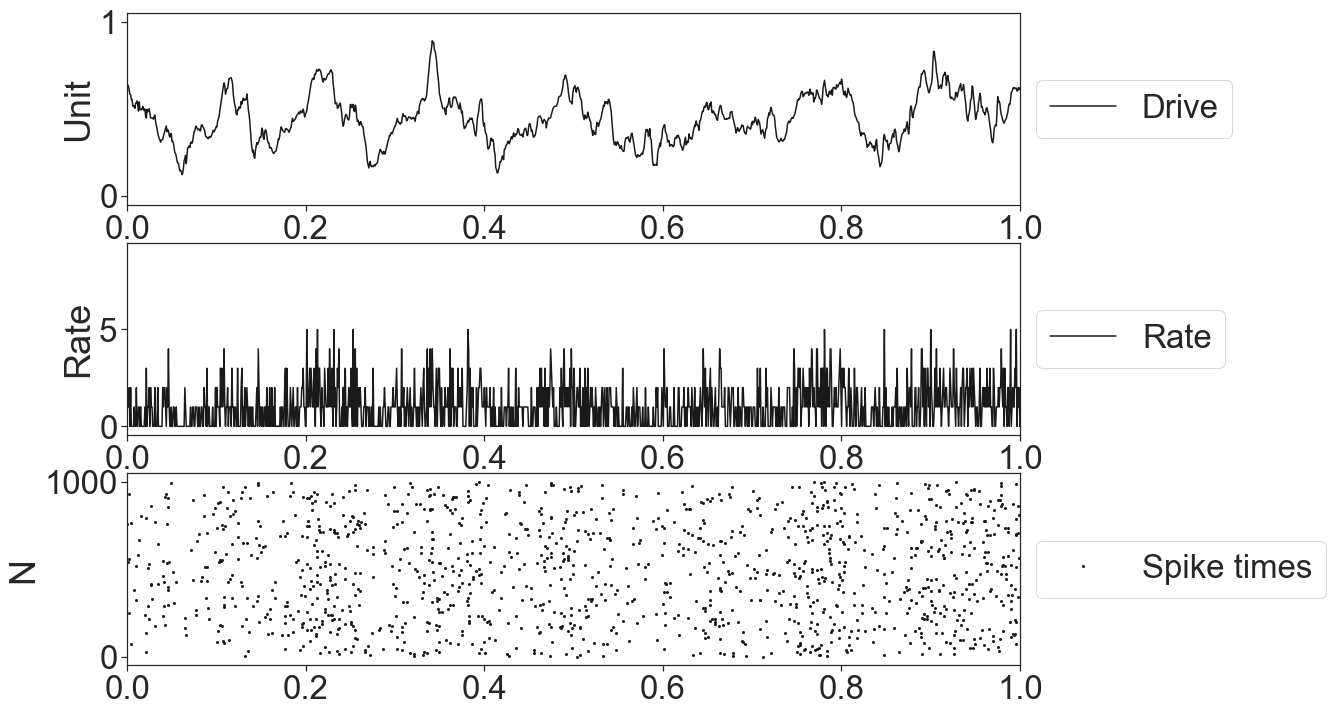

In [95]:
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(3, figsize=(16, 12))

_ = ax[0].plot(lfp_times, drive, marker='', linestyle='-', color='k', 
               label='Drive')
_ = ax[0].set_ylabel("Unit")
_ = ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax[0].set_xlim(0, 1)

_ = ax[1].plot(lfp_times[0:-1], firing_rate.sum(1), marker='', linestyle='-', color='k', 
               label='Rate')
_ = ax[1].set_ylabel("Rate")
_ = ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax[1].set_xlim(0, 1)

_ = ax[2].plot(ts, ns, markersize=2, marker='o', linestyle='', color='k', 
               label='Spike times')
_ = ax[2].set_ylabel("N")
_ = ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax[2].set_xlim(0, 1)